# Deep Weak Stochastic Processes

# Training Algorithm
---
Given a set of training inputs $\mathbb{X}$ and a stochastic process $(X_t)_{t\geq 0}$ which we can sample from:
1. **For:** x in $\mathbb{X}$:
    - *Simulate:* $\{x\mapsto X_T(\omega_n)\}_{n=1}^N$
    - *Set*: $\hat{\nu}_{x,T}\triangleq \frac1{N}\sum_{n=1}^N \delta_{X_T(\omega_n)}$
2. **Learn:** Wasserstein Barycenters $\hat{\mu}_1,\dots,\hat{\mu}_N
    \in \underset{{\hat{\mu}_n\in\mathscr{P}_{N}(\mathbb{R}^d)}}{\operatorname{argmin}}
    \, \sum_{n=1}^N W_1(\hat{\mu_n},\hat{\nu}_{x,T})$
3. **Train Classifier:** $\hat{f}:x\mapsto \operatorname{n\leq N}\, W_1(\hat{\mu_n},\hat{\nu}_{x,T})$

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = .3
min_height = 50

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [3]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [4]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready


### Set Seed

In [13]:
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

---

### Simulate Path
$d X_t = \alpha(t,x)dt + \beta(t,x)dW_t ;\qquad X_0 =x$

### Drift

In [14]:
def alpha(t,x):
    return np.sin(math.pi*t)

### Volatility

In [15]:
def beta(t,x):
    return (t+1)**.5

## Initialize Grid
This is $\mathbb{X}$ and it represents the grid of initial states.

In [16]:
x_Grid = np.arange(start=-1,stop=1,step=0.01)

### Path Generator

In [17]:
def Euler_Maruyama_Generator(N_Euler_Maruyama_Steps = 100,
                             N_Monte_Carlo_Samples = 50,
                             x_0 = 0,
                             T = 1): 
    
    #----------------------------#    
    # DEFINE INTERNAL PARAMETERS #
    #----------------------------#
    # Initialize Empirical Measure
    X_T_Empirical = np.zeros(N_Monte_Carlo_Samples)


    # Internal Initialization(s)
    ## Initialize current state
    n_sample = 0
    ## Initialize Incriments
    dt = T/N_Euler_Maruyama_Steps
    sqrt_dt = np.sqrt(dt)

    #-----------------------------#    
    # Generate Monte-Carlo Sample #
    #-----------------------------#
    while n_sample < N_Monte_Carlo_Samples:
        # Reset Step Counter
        t = 1
        # Initialize Current State 
        X_current = x_0
        # Perform Euler-Maruyama Simulation
        while t<N_Euler_Maruyama_Steps:
            # Update Internal Parameters
            ## Get Current Time
            t_current = t*(T/N_Euler_Maruyama_Steps)

            # Update Generated Path
            X_current = X_current + alpha(t_current,X_current)*dt + beta(t_current,X_current)*np.random.normal(0,sqrt_dt)

            # Update Counter (EM)
            t = t+1

        # Update Empirical Measure
        X_T_Empirical[n_sample] = X_current

        # Update Counter (MC)
        n_sample = n_sample + 1

    return X_T_Empirical.reshape(1,-1)

(array([ 2.,  2.,  6.,  9.,  5., 11.,  6.,  3.,  3.,  3.]),
 array([-2.31932142, -1.71815111, -1.11698079, -0.51581048,  0.08535983,
         0.68653015,  1.28770046,  1.88887078,  2.49004109,  3.0912114 ,
         3.69238172]),
 <a list of 10 Patch objects>)

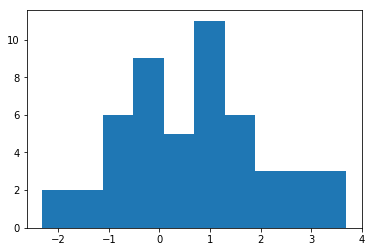

In [440]:
plt.hist(X_T_Empirical)

---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [65]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [66]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(training_quality,axis=-1)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
# Build Classes
for part_column_i in range(1,(training_quality.shape[1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [67]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


#### Train Deep Classifier

In [68]:
# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = partition_labels_training,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   24.5s finished


94/94 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.3463
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.3773
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.4257
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.4360
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0840 - accuracy: 0.4513
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.4690
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.4887
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.4957
Epoch 9/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.5087
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.5023
Epoch 11/200
94/94 [=

94/94 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.7673
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.7610
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.7630
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7647
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7513
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.7630
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.7497
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7527
Epoch 172/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.7550
Epoch 173/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.7480
Epoc

In [69]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

Make Prediction(s)

In [70]:
# Training Set
Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Write Predictions

Compute Performance

In [71]:
# Compute Peformance
performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

# Update User
print(performance_Architope)

          train       test
MAE    0.112921   0.112921
MSE    0.040453   0.040453
MAPE  41.261743  41.261743


---

---

---

### Model Complexity/Efficiency Metrics

In [72]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

      L-time    P-time  N_params_expt    AIC-like    Eff
0  87.438187  4.224885         251826  503656.362  1.404


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [73]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [74]:
parameters = {'penalty': ['none','l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [75]:
# Update User on shape of learned partition
print(partition_labels_training)

[0 0 0 ... 2 2 2]


In [76]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=2020,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 10, 100, 1000],
                                        'penalty': ['none', 'l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=2020, refit=True,
                   return_train_score=False, scoring

#### Write Predicted Class(es)

In [77]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [78]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [79]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

          train       test
MAE    0.154933   0.154933
MSE    0.048416   0.048416
MAPE  82.255966  82.255966


---
## Bagged Feed-Forward Networks (ffNNs)

In [80]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [81]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [82]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [83]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

Written Bagged Performance
          train       test
MAE    0.140856   0.140856
MSE    0.036391   0.036391
MAPE  74.566549  74.566549


In [84]:
print("Random Partition: Generated!...Feature Generation Complete!")

Random Partition: Generated!...Feature Generation Complete!


## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [85]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


In [86]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [87]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                   n_jobs = n_jobs, 
                                                                                   n_iter = n_iter, 
                                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                                   X_train=X_train, 
                                                                                   y_train=data_y, 
                                                                                   X_test_partial=X_train,
                                                                                   X_test=X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.6s finished


Epoch 1/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1618 - mse: 0.0656 - mae: 0.1618 - mape: 323.4833
Epoch 2/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1562 - mse: 0.0522 - mae: 0.1562 - mape: 314.5051
Epoch 3/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1554 - mse: 0.0489 - mae: 0.1554 - mape: 360.7039
Epoch 4/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1543 - mse: 0.0464 - mae: 0.1543 - mape: 404.8835
Epoch 5/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1535 - mse: 0.0441 - mae: 0.1535 - mape: 498.3145
Epoch 6/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1523 - mse: 0.0438 - mae: 0.1523 - mape: 526.3344
Epoch 7/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1513 - mse: 0.0442 - mae: 0.1513 - mape: 560.9385
Epoch 8/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1505 - mse: 0.0458 - mae: 0.1505 - mape: 556.6848
Epoch 9/

In [88]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [89]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

Trained vanilla ffNNs


#### Evaluate Performance

In [90]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

Written Bagged Vanilla ffNNs
          train       test
MAE    0.140784   0.140784
MSE    0.063841   0.063841
MAPE  73.887985  73.887985


#### Compute Required Training Time(s)

In [91]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [92]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Writing preliminary table: Required Training Times
   Architope  Architope-logistic Vanilla ffNN  Bagged ffNN
0    155.646             117.403       15.185       88.895
0     72.433              34.190            -        5.682


## Run: Gradient Boosted Random Forest Regression

In [93]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.151008   0.151008
MSE    0.033405   0.033405
MAPE  77.563713  77.563713
Training of Gradient-Boosted Random Forest: Complete!


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0225s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s finished


## Training Result(s)
#### (Update) Write Required Training Times

In [94]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Completing Table: Required Training Times
                   In-Line (L-Time) Parallel (P-Time)
Vanilla ffNN                 15.185                 -
Grad.Bstd Rand.F              0.084                 -
Bagged ffNN                  88.895             5.682
Architope-logistic          117.403             34.19
Architope                   155.646            72.433


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [95]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

               MAE       MSE       MAPE
ffNN      0.140784  0.063841  73.887985
GBRF      0.151008  0.033405  77.563713
ffNN-bag  0.140856  0.036391  74.566549
ffNN-lgt  0.154933  0.048416  82.255966
tope      0.112921  0.040453  41.261743


### Model Complexity/Efficiency Metrics

In [96]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

                   In-Line (L-Time) Parallel (P-Time)   N_par    AIC_like  \
Vanilla ffNN                 15.185                 -   10401   20805.921   
Grad.Bstd Rand.F              0.084                 -      70     143.781   
Bagged ffNN                  88.895             5.682  164427  328857.920   
Architope-logistic          117.403             34.19  164453  328909.730   
Architope                   155.646            72.433  251826  503656.362   

                      Eff  
Vanilla ffNN        1.302  
Grad.Bstd Rand.F    0.642  
Bagged ffNN         1.692  
Architope-logistic  1.861  
Architope           1.404  


# Summary

In [97]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

 
 
#-------------------#
 PERFORMANCE SUMMARY:
#-------------------#
 
 
#===================#
 Individual Metrics: 
#======-============#
 
----------------------------------------
----------------------------------------
Architope (Full)
----------------------------------------
          train       test
MAE    0.112921   0.112921
MSE    0.040453   0.040453
MAPE  41.261743  41.261743
----------------------------------------
Architope - Naive Logistic
----------------------------------------
          train       test
MAE    0.154933   0.154933
MSE    0.048416   0.048416
MAPE  82.255966  82.255966
----------------------------------------
Vanilla ffNN
----------------------------------------
          train       test
MAE    0.140784   0.140784
MSE    0.063841   0.063841
MAPE  73.887985  73.887985
----------------------------------------
Bagged ffNN
----------------------------------------
          train       test
MAE    0.140856   0.140856
MSE    0.036391   0.036391
MAPE  74.566549

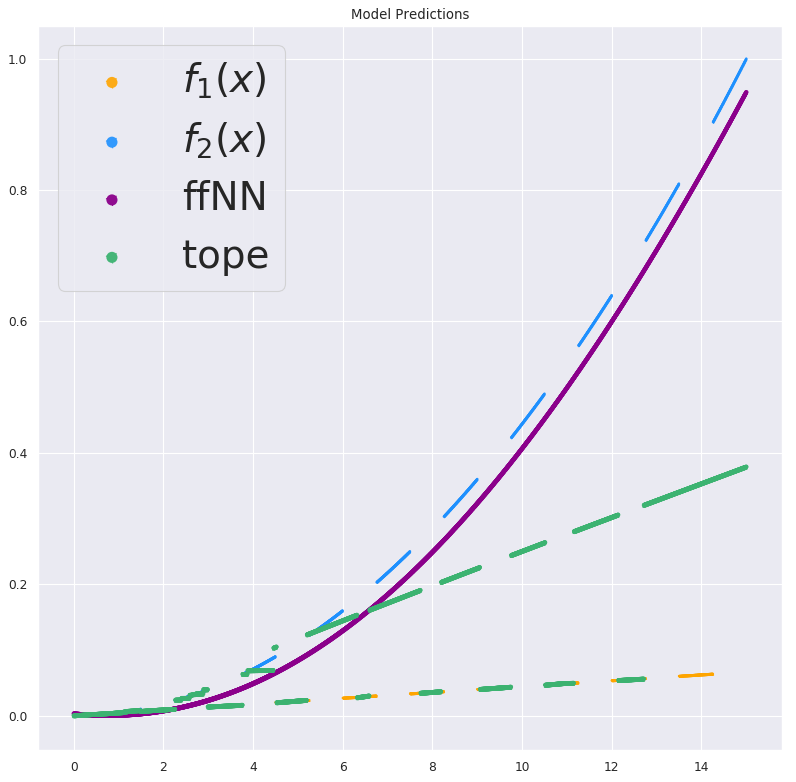

In [98]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='orange',label=r'$f_1(x)$',linestyle=(0,(1,10)),s=5,alpha=.9)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,10)),s=5,alpha=.9)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=15,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=15,alpha=.95)



# Format Plot #
#-------------#
# Plot legend.
lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=35)
plt.title("Model Predictions")
# Format
for handle in lgnd.legendHandles:
    handle.set_sizes([100])
# plt.show()

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO_Seaborn.eps', format='eps')

---
# Fin
---